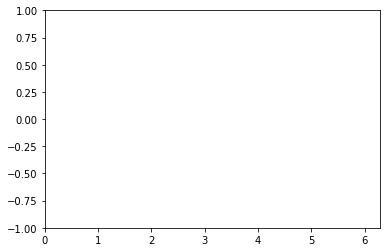

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cvxpy as cp

import config
import core
import os
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation


plt.ion()
plt.close()
fig, ax = plt.subplots(figsize=(7, 7))

net = core.CLF_QP_Net(4, 256, 2)
net.load_state_dict(torch.load('./logs/model.pth'))
net.eval()

nominal_controller = core.LQR()

for i in range(20):
    rho_init = np.random.uniform(10, 12)
    theta_init = np.random.uniform(np.pi/4, np.pi/3)
    v_init = np.random.uniform(-1, 1, size=2)
    s = np.array([[np.cos(theta_init) * rho_init, 
                  np.sin(theta_init) * rho_init,
                  v_init[0], v_init[1]]], dtype=np.float32)

    s = torch.from_numpy(s)

    for j in range(config.NUM_STEPS_PER_EPOCH):

        u_nominal = nominal_controller(np.squeeze(s.detach().numpy()))
        
        use_nominal = False
        s_np = np.squeeze(s.numpy())
        if s_np[1] < 0 and abs(s_np[0]) < abs(s_np[1]):
            u = torch.from_numpy(np.expand_dims(u_nominal, 0).astype(np.float32))
            use_nominal = True

        else:
            V, grad_V = net.compute_lyapunov(s)
            grad_V_np = np.squeeze(grad_V.detach().numpy())
            V_np = np.squeeze(V.detach().numpy())

            s_np = s.numpy()
            u = cp.Variable(2)
            clf_cond = grad_V_np @ (core.A.dot(s_np[0]) + core.B @ u) + 0.005 * V_np
            constraint = [clf_cond <= 0]

            objective = cp.Minimize(cp.sum_squares(u-u_nominal))

            cp.Problem(objective, constraint).solve()
            u = u.value
            u = torch.from_numpy(np.expand_dims(u, 0).astype(np.float32))

        dsdt = core.dynamics_torch(s, u)

        if use_nominal:
            timestep = config.TIME_STEP * 0.7
        else:
            timestep = config.TIME_STEP * 1.0

        s = torch.clip(s + dsdt * timestep, -7, 7)

        plt.clf()
        plt.scatter(s[0, 0].detach().numpy(), s[0, 1].detach().numpy(), s=100)

        ax = fig.gca()
        ax.add_patch(plt.Circle((0, 0), 4, color='g', alpha=0.3, fill=False, linewidth=2, linestyle='--'))
        ax.plot([0, -2.8], [0, -2.8], color='g', alpha=0.3, linewidth=2, linestyle='--')
        ax.plot([0, 2.8], [0, -2.8], color='g', alpha=0.3, linewidth=2, linestyle='--')

        ax.add_patch(patches.Wedge((0, 0), 4, -135, -45, linewidth=2,
                         edgecolor='g', facecolor='g', fill=True, alpha=0.3))

        plt.xlim(-12, 12)
        plt.ylim(-11, 12)

        plt.axis('off')

        fname=fig.canvas.draw()
        plt.pause(0.01)
        

        

ModuleNotFoundError: No module named 'casadi'

In [6]:
%run test.py

Exception: File `'test.py'` not found.